In [2]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *

import sys
sys.path.append('../../../scripts/')
from PreparaDatasetV2 import *

# Parâmetros do método

In [3]:
TARGET = 'Back_Over'
ODDS = 'Odds_Over'

# Carregando o dataset

In [4]:
data = pd.read_csv('../../../data/entire_season.csv')
data = prepara_df(data)

In [5]:
def prepara_dataset(_df):
    _df = _df[_df['Date'] > '2023-10-19']

    # Limpa _df
    _df.replace([np.inf, -np.inf], 0, inplace=True)
    # _df.dropna(subset=['Avg_CG_H', 'Avg_CG_A', TARGET], inplace=True)

    _df.reset_index(drop=True, inplace=True)

    return _df

In [6]:
df = prepara_dataset(data)

In [7]:
TRAIN_SIZE = 700

treino = df.iloc[:TRAIN_SIZE, :]
val = df.iloc[TRAIN_SIZE: , :]

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')
print(f"Odd média: {treino[ODDS].mean():.2f}")
print(f"WR: {treino[TARGET].mean():.2f} (Odd justa: {1 / treino[TARGET].mean():.2f})")

Treino: 700 | Validação: 919
Odd média: 1.80
WR: 0.53 (Odd justa: 1.90)


# Validação 2

In [8]:
VAL2_SIZE = 0.5

div = int(VAL2_SIZE * len(val))
val1 = val.iloc[:div, :]
val2 = val.iloc[div: , :]

print(f'Validação 1: {val1.shape[0]} | Validação 2: {val2.shape[0]}')

Validação 1: 459 | Validação 2: 460


# Criação do modelo

In [30]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA', ODDS]

features = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA', ODDS]

features = ['Odds_A', 'CV_ML', 'P(U)', 'P(O)', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Last_CG_H', 'Last_CG_A', 'Odds_Over']

In [31]:
def cria_setup(seed = 2023, features = features):
    cls = setup(data = treino,
            ignore_features = [x for x in treino.columns.to_list() if x not in features and x != TARGET],
            target = TARGET,
            train_size = 0.5,
            normalize = True,
            normalize_method = 'minmax',
            session_id = seed,
            remove_outliers = True,
            fix_imbalance = True,
            verbose = False
            )

In [32]:
cria_setup(seed = 2023, features = features)

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [34]:
top = compare_models(exclude=['catboost', 'dummy'], fold = 5, sort='precision', n_select=14)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.5686,0.5879,0.5760,0.5964,0.5830,0.1357,0.1377,0.0780
rf,Random Forest Classifier,0.5629,0.5782,0.5486,0.5923,0.5689,0.1259,0.1268,0.0920
xgboost,Extreme Gradient Boosting,0.5600,0.5571,0.5593,0.5847,0.5700,0.1190,0.1199,0.0640
lightgbm,Light Gradient Boosting Machine,0.5571,0.5699,0.5489,0.5829,0.5649,0.1148,0.1150,0.0760
lr,Logistic Regression,0.5657,0.5716,0.6518,0.5758,0.6106,0.1225,0.1247,0.0540
qda,Quadratic Discriminant Analysis,0.5114,0.5696,0.2775,0.5719,0.3699,0.0475,0.0552,0.0460
ridge,Ridge Classifier,0.5629,0.0000,0.6520,0.5708,0.6067,0.1170,0.1215,0.0500
lda,Linear Discriminant Analysis,0.5486,0.5430,0.6192,0.5626,0.5876,0.0896,0.0914,0.0440
svm,SVM - Linear Kernel,0.5257,0.0000,0.5575,0.5603,0.4726,0.0435,0.0377,0.0520
ada,Ada Boost Classifier,0.5343,0.5207,0.5375,0.5599,0.5461,0.0675,0.0684,0.0580


In [37]:
model = create_model('nb', cross_validation=False, return_train_score=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.5114,0.4863,0.5405,0.5376,0.5391,0.0193,0.0193
Train,0.5543,0.5658,0.6250,0.5693,0.5959,0.1014,0.1020


In [66]:
# Ranges da variável
ranges_dict['Last_CG_H']

[Interval(-0.001, 130.98, closed='right'),
 Interval(183.0, 1485.0, closed='right')]

In [68]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[_df['prediction_label'] == 1]

    if filtro == 1:
        _df = _df[((_df['Last_CG_H'] >= 0) & (_df['Last_CG_H'] < 130)) | ((_df['Last_CG_H'] >= 183) & (_df['Last_CG_H'] < 1485))]
    
    return _df

In [14]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = [plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]
        return metrics

def exibe_grafico(_df, per_day = False):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    if per_day:
        
        _df['Date'] = pd.to_datetime(_df['Date'])
        _df_per_day = _df.groupby(_df['Date'].dt.date)['PL_BF_Predictions'].sum()
        _df_per_day = _df_per_day.reset_index()
        
        # Criar um novo DataFrame com colunas 'Date' e 'Accumulated'
        new_df = pd.DataFrame({
            'Date': _df_per_day['Date'],
            'PL': _df_per_day['PL_BF_Predictions']
        })

        new_df['hbacu'] = new_df['PL'].cumsum()
        new_df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por dia')
        plt.show()

    else:
        _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
        _df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por jogo')
        plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df[[TARGET, 'Date']], left_index=True, right_index=True, how='left')
    if f'{TARGET}_x' in _df.columns.tolist():
        _df.rename(columns={f'{TARGET}_x': TARGET}, inplace=True)
        _df.drop(columns=f'{TARGET}_y', inplace=True)
    if 'Date_x' in _df.columns.tolist():
        _df.rename(columns={'Date_x': 'Date'}, inplace=True)
        _df.drop(columns='Date_y', inplace=True)
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0, per_day = False):
    total = data.shape[0]

    _df = treina_modelo(modelo, data)
    _df = filtra_resultados(_df, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df, per_day)
    
    return _df


PL: 21.06 | ROI: 12.54% | Prec.: 0.59
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.13
168 entradas em 350 jogos (48.00%)


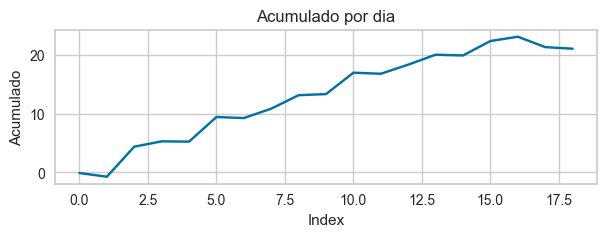

PL: 5.30 | ROI: 3.61% | Prec.: 0.54
Odd média: 1.91 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.03
147 entradas em 350 jogos (42.00%)


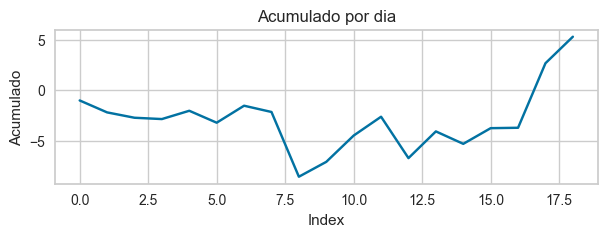

PL: 26.36 | ROI: 8.37% | Prec.: 0.57
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.09
315 entradas em 700 jogos (45.00%)


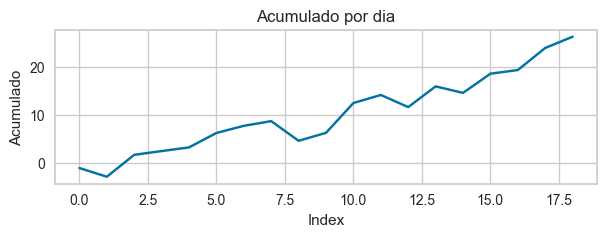

In [81]:
mdl = model
flt = 1
df_treino = info_modelo(mdl, real_treino, filtro = flt, per_day=True)
df_teste = info_modelo(mdl, real_teste, filtro = flt, per_day=True)
df_comp = info_modelo(mdl, treino, filtro = flt, per_day=True)

PL: 18.63 | ROI: 10.18% | Prec.: 0.59
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.10
183 entradas em 919 jogos (19.91%)


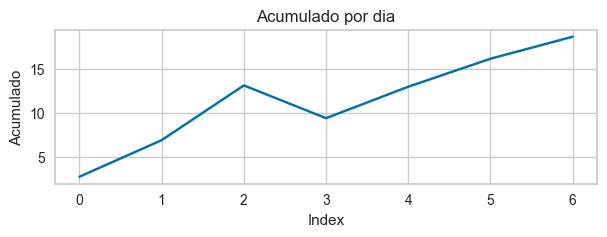

In [77]:
df_val = info_modelo(mdl, val, filtro = flt, per_day=True)

PL: 44.99 | ROI: 9.03% | Prec.: 0.58
Odd média: 1.89 (0.53 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.10
498 entradas em 1619 jogos (30.76%)


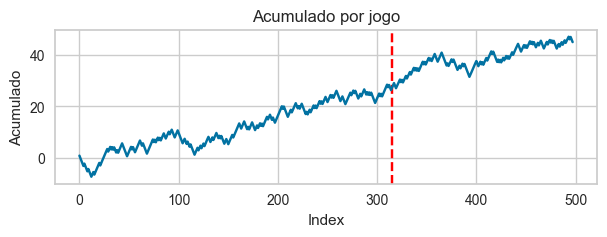

In [78]:
aux_comp = treina_modelo(mdl, treino)
aux_comp = filtra_resultados(aux_comp, filtro = flt)
plt.axvline(x=len(aux_comp), color='red', linestyle='--')
aux = info_modelo(mdl, pd.concat([treino, val]), filtro = flt)

# QCut automático

In [64]:
def find_pos_range(var, treino, teste, validacao, ratio = 0.03, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_top_range(var, treino, teste, validacao, ratio = 3, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:ratio]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_neg_range(var, treino, teste, validacao, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = validacao[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    treino_filtrado = treino[mascara_treino]
    teste_filtrado = teste[mascara_teste]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges

In [63]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()
autocut_val = df_val.copy()

Odds_A

---------------------  TREINO  ---------------------
PL: 8.28 | ROI: 9.10% | Prec.: 0.57
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.09
91 entradas em 350 jogos (26.00%)


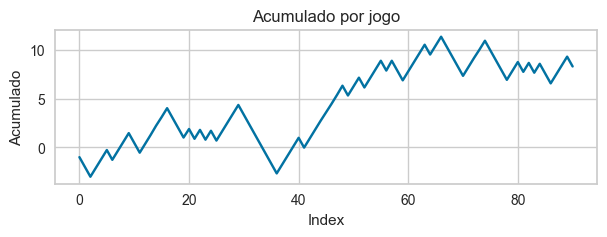

---------------------  TESTE  ---------------------
PL: 21.17 | ROI: 29.40% | Prec.: 0.68
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.29
72 entradas em 350 jogos (20.57%)


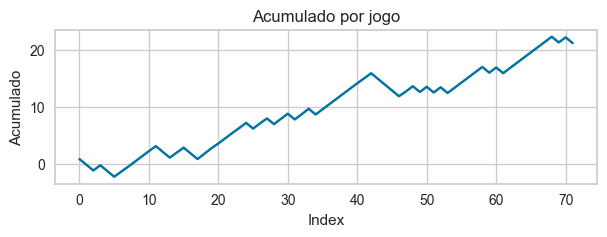

---------------------  VALIDAÇÃO  ---------------------
PL: -3.03 | ROI: -3.03% | Prec.: 0.52
Odd média: 1.86 (0.54 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: -0.03
100 entradas em 919 jogos (10.88%)


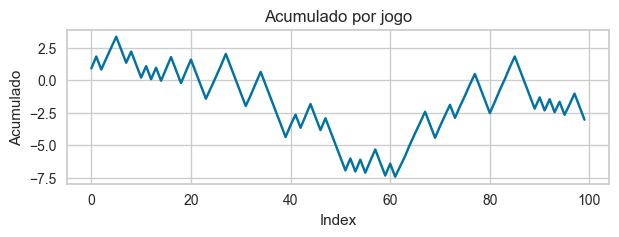




CV_ML

---------------------  TREINO  ---------------------
PL: -1.29 | ROI: -1.74% | Prec.: 0.51
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: -0.02
74 entradas em 350 jogos (21.14%)


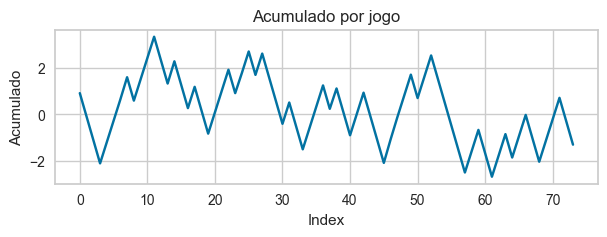

---------------------  TESTE  ---------------------
PL: 13.42 | ROI: 17.66% | Prec.: 0.62
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.18
76 entradas em 350 jogos (21.71%)


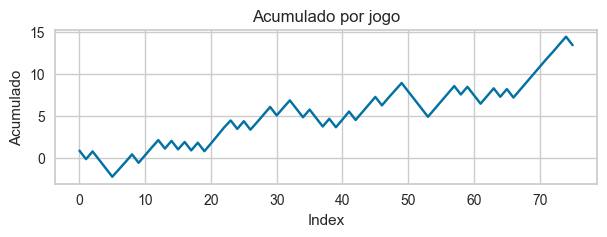

---------------------  VALIDAÇÃO  ---------------------
PL: 6.45 | ROI: 6.58% | Prec.: 0.57
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.06
98 entradas em 919 jogos (10.66%)


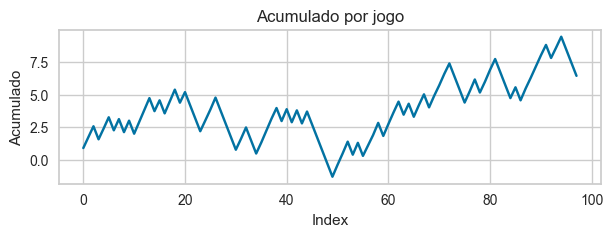




P(U)

---------------------  TREINO  ---------------------
PL: 6.81 | ROI: 37.83% | Prec.: 0.72
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.37
18 entradas em 350 jogos (5.14%)


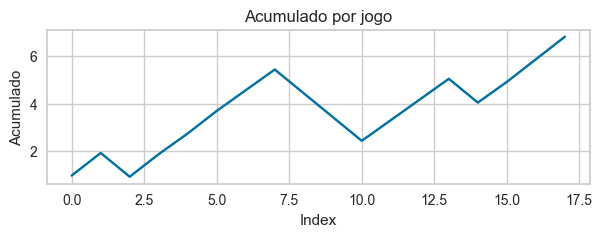

---------------------  TESTE  ---------------------
PL: 2.47 | ROI: 9.50% | Prec.: 0.58
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.10
26 entradas em 350 jogos (7.43%)


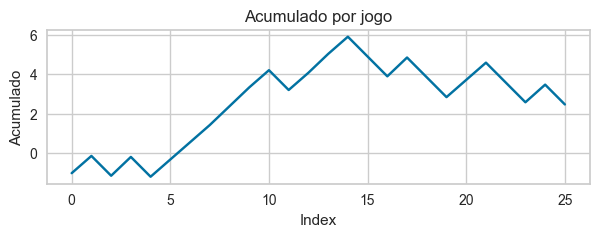

---------------------  VALIDAÇÃO  ---------------------
PL: 0.04 | ROI: 0.09% | Prec.: 0.53
Odd média: 1.87 (0.53 WR)
Média Gain: 0.88 | Média Loss: -1.00
EM: -0.01
45 entradas em 919 jogos (4.90%)


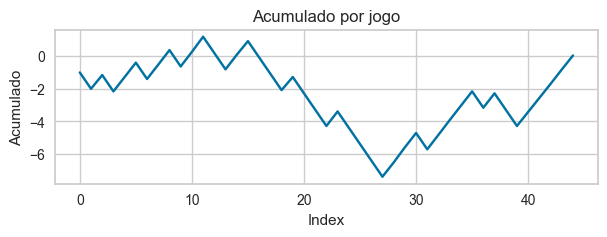




P(O)

---------------------  TREINO  ---------------------
PL: -0.32 | ROI: -1.68% | Prec.: 0.53
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: -0.01
19 entradas em 350 jogos (5.43%)


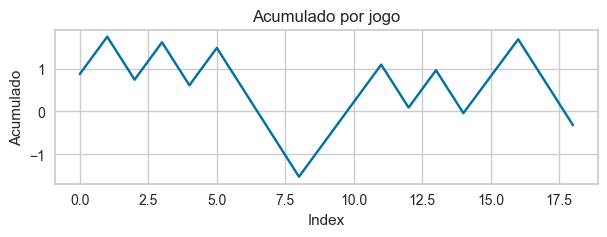

---------------------  TESTE  ---------------------
PL: 8.51 | ROI: 34.04% | Prec.: 0.72
Odd média: 1.86 (0.54 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: 0.34
25 entradas em 350 jogos (7.14%)


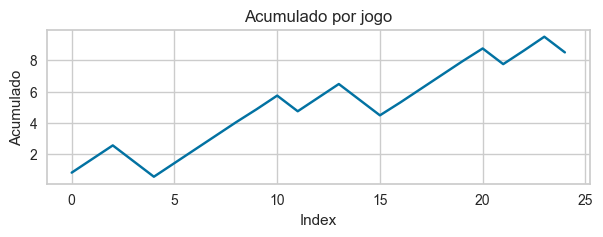

---------------------  VALIDAÇÃO  ---------------------
PL: 4.62 | ROI: 4.40% | Prec.: 0.56
Odd média: 1.86 (0.54 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: 0.04
105 entradas em 919 jogos (11.43%)


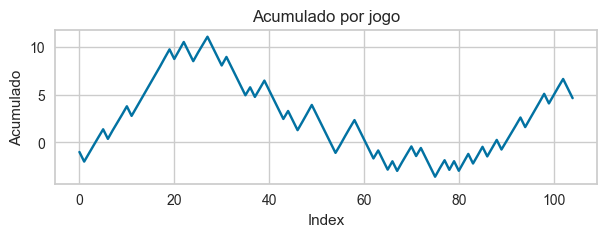




P_Diff

---------------------  TREINO  ---------------------
PL: 10.41 | ROI: 8.20% | Prec.: 0.57
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.09
127 entradas em 350 jogos (36.29%)


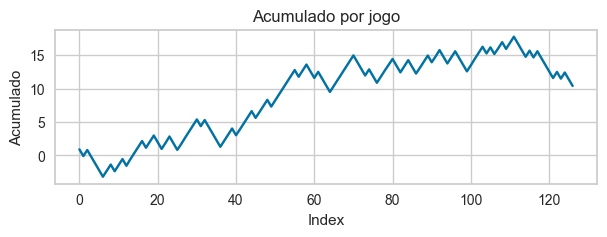

---------------------  TESTE  ---------------------
PL: 8.87 | ROI: 7.99% | Prec.: 0.57
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.08
111 entradas em 350 jogos (31.71%)


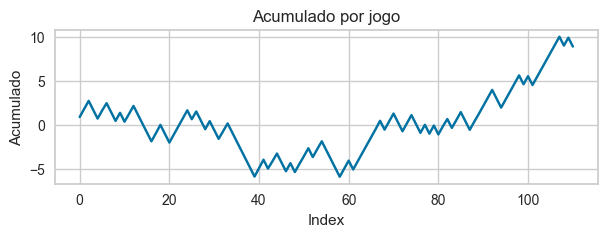

---------------------  VALIDAÇÃO  ---------------------
PL: 7.69 | ROI: 6.15% | Prec.: 0.57
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.07
125 entradas em 919 jogos (13.60%)


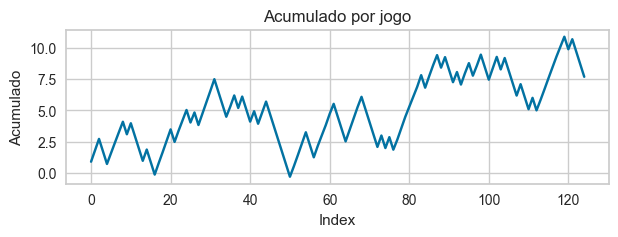




HA_Odds_A

---------------------  TREINO  ---------------------
PL: -1.81 | ROI: -4.31% | Prec.: 0.50
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: -0.04
42 entradas em 350 jogos (12.00%)


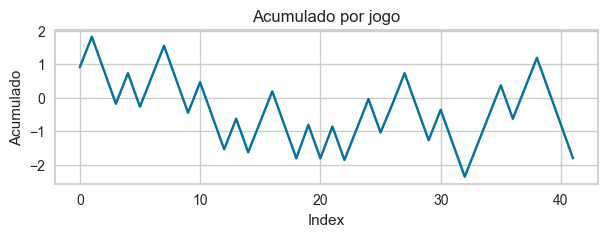

---------------------  TESTE  ---------------------
PL: 5.03 | ROI: 16.23% | Prec.: 0.61
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.16
31 entradas em 350 jogos (8.86%)


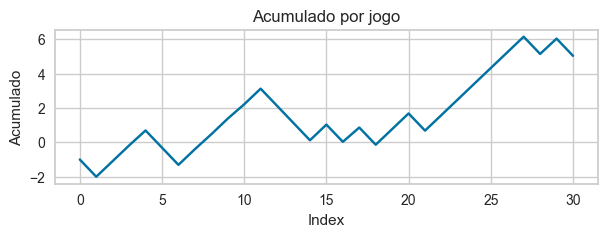

---------------------  VALIDAÇÃO  ---------------------
PL: 11.75 | ROI: 6.18% | Prec.: 0.57
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.06
190 entradas em 919 jogos (20.67%)


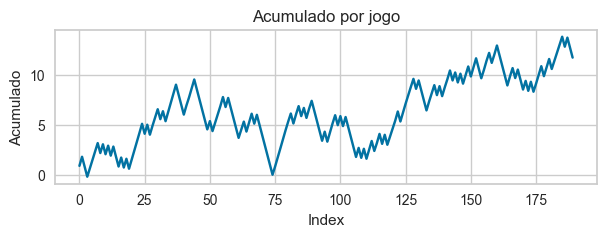




HA_Line

---------------------  TREINO  ---------------------
PL: 7.78 | ROI: 9.49% | Prec.: 0.57
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.09
82 entradas em 350 jogos (23.43%)


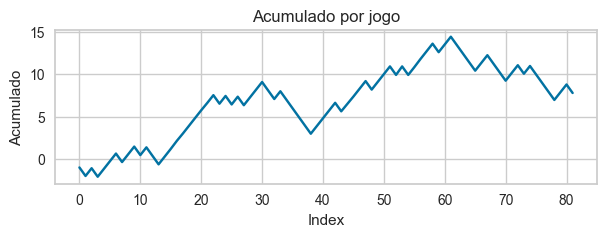

---------------------  TESTE  ---------------------
PL: 18.82 | ROI: 23.52% | Prec.: 0.65
Odd média: 1.90 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.24
80 entradas em 350 jogos (22.86%)


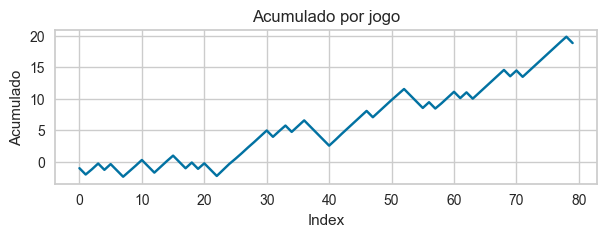

---------------------  VALIDAÇÃO  ---------------------
PL: -10.54 | ROI: -9.33% | Prec.: 0.49
Odd média: 1.86 (0.54 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: -0.09
113 entradas em 919 jogos (12.30%)


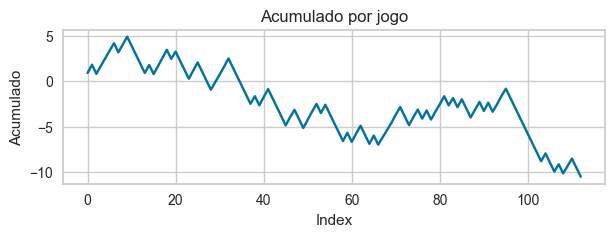




Odds_Under

---------------------  TREINO  ---------------------
PL: -1.41 | ROI: -20.14% | Prec.: 0.43
Odd média: 1.86 (0.54 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: -0.20
7 entradas em 350 jogos (2.00%)


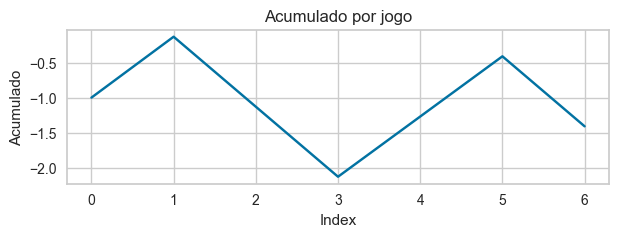

---------------------  TESTE  ---------------------
PL: 2.30 | ROI: 32.86% | Prec.: 0.71
Odd média: 1.85 (0.54 WR)
Média Gain: 0.86 | Média Loss: -1.00
EM: 0.32
7 entradas em 350 jogos (2.00%)


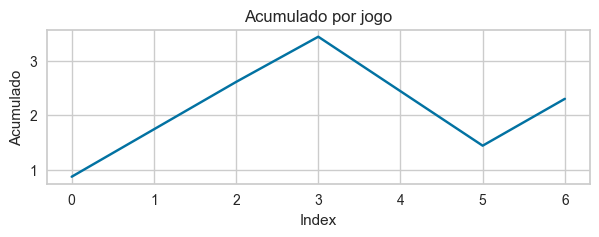

---------------------  VALIDAÇÃO  ---------------------
PL: 4.07 | ROI: 5.58% | Prec.: 0.58
Odd média: 1.83 (0.55 WR)
Média Gain: 0.83 | Média Loss: -1.00
EM: 0.06
73 entradas em 919 jogos (7.94%)


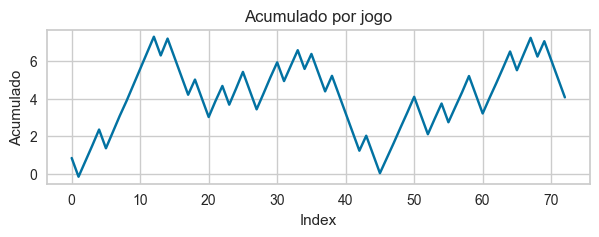




Last_CG_H

---------------------  TREINO  ---------------------
PL: 21.06 | ROI: 12.54% | Prec.: 0.59
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.13
168 entradas em 350 jogos (48.00%)


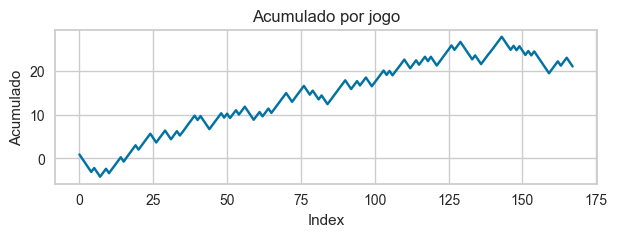

---------------------  TESTE  ---------------------
PL: 8.91 | ROI: 5.98% | Prec.: 0.56
Odd média: 1.91 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.07
149 entradas em 350 jogos (42.57%)


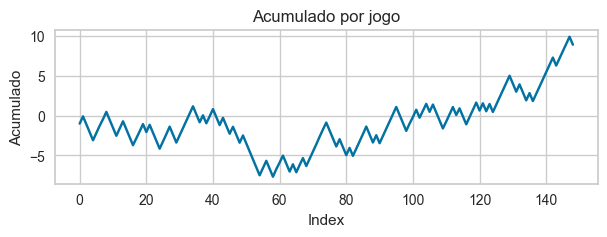

---------------------  VALIDAÇÃO  ---------------------
PL: 18.63 | ROI: 10.18% | Prec.: 0.59
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.10
183 entradas em 919 jogos (19.91%)


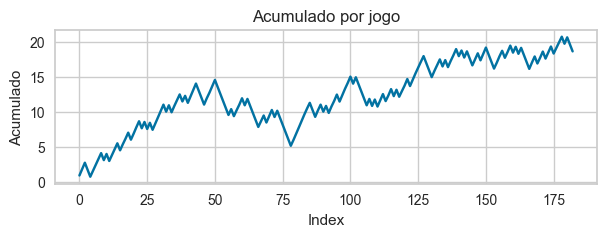




Last_CG_A

---------------------  TREINO  ---------------------
PL: 10.24 | ROI: 7.37% | Prec.: 0.56
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.07
139 entradas em 350 jogos (39.71%)


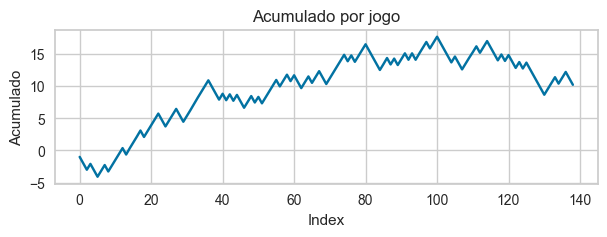

---------------------  TESTE  ---------------------
PL: 12.89 | ROI: 11.61% | Prec.: 0.59
Odd média: 1.91 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.12
111 entradas em 350 jogos (31.71%)


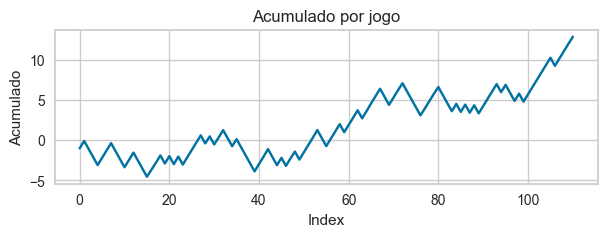

---------------------  VALIDAÇÃO  ---------------------
PL: 16.05 | ROI: 22.61% | Prec.: 0.65
Odd média: 1.89 (0.53 WR)
Média Gain: 0.89 | Média Loss: -1.00
EM: 0.23
71 entradas em 919 jogos (7.73%)


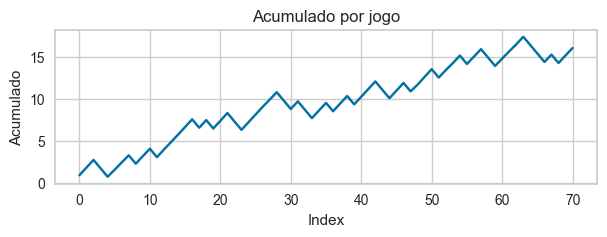




Odds_Over

---------------------  TREINO  ---------------------
PL: 15.86 | ROI: 8.35% | Prec.: 0.57
Odd média: 1.90 (0.52 WR)
Média Gain: 0.91 | Média Loss: -1.00
EM: 0.09
190 entradas em 350 jogos (54.29%)


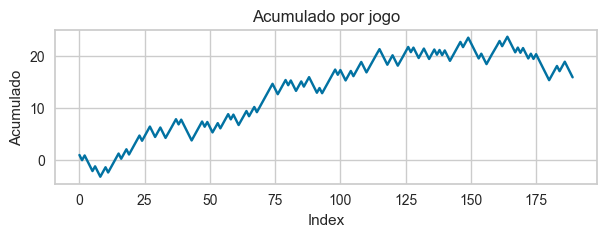

---------------------  TESTE  ---------------------
PL: 5.58 | ROI: 3.19% | Prec.: 0.54
Odd média: 1.90 (0.53 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.03
175 entradas em 350 jogos (50.00%)


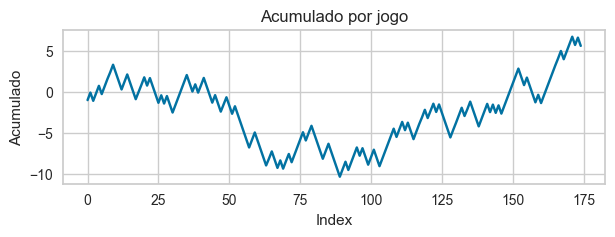

---------------------  VALIDAÇÃO  ---------------------
PL: 16.75 | ROI: 9.80% | Prec.: 0.58
Odd média: 1.87 (0.53 WR)
Média Gain: 0.88 | Média Loss: -1.00
EM: 0.09
171 entradas em 919 jogos (18.61%)


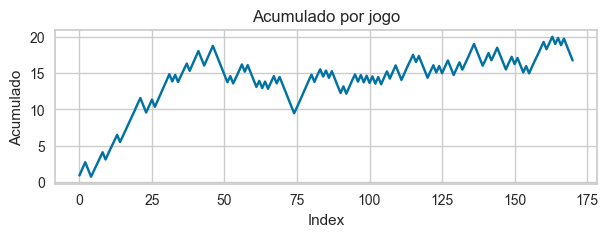

In [65]:
variaveis = features.copy()

ranges_dict = {}

for var in variaveis:
    try:
        new_range = find_pos_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 0.02, return_train=True, return_val=True)
        # new_range = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, validacao=autocut_val, return_train=True, return_val=True)
        ranges_dict[var] = new_range
    except:
        pass

# Comparação de modelos

### Escolhendo os modelos

SGDClassifier (i = 0)

PL: -17.09 | ROI: -89.95% | Prec.: 1.00
Odd média: 0.10 (9.95 WR)
Média Gain: -0.90 | Média Loss: nan
EM: nan
19 entradas em 350 jogos (5.43%)


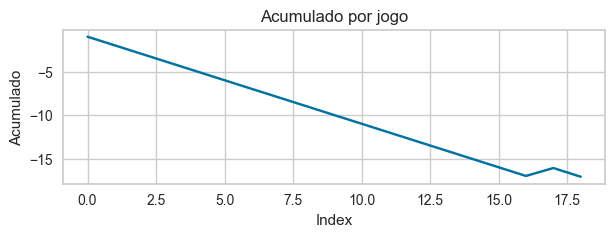

KNeighborsClassifier (i = 1)

PL: -24.00 | ROI: -14.04% | Prec.: 0.49
Odd média: 1.82 (0.55 WR)
Média Gain: 0.75 | Média Loss: -1.00
EM: -0.14
171 entradas em 350 jogos (48.86%)


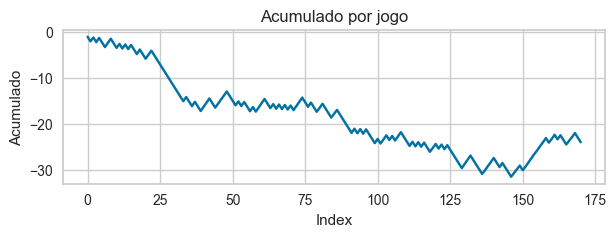

LGBMClassifier (i = 2)

PL: -3.52 | ROI: -1.99% | Prec.: 0.55
Odd média: 1.82 (0.55 WR)
Média Gain: 0.77 | Média Loss: -1.00
EM: -0.03
177 entradas em 350 jogos (50.57%)


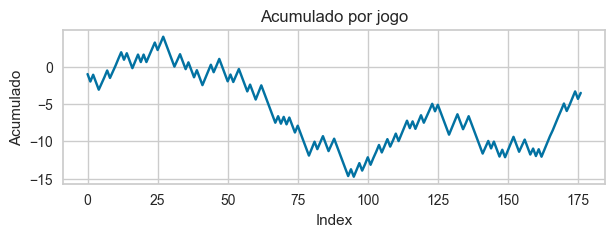

RidgeClassifier (i = 3)

PL: -19.39 | ROI: -10.15% | Prec.: 0.57
Odd média: 1.73 (0.58 WR)
Média Gain: 0.59 | Média Loss: -1.00
EM: -0.09
191 entradas em 350 jogos (54.57%)


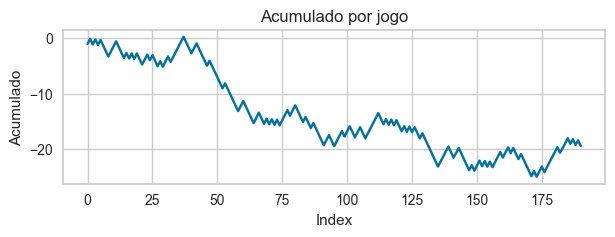

LogisticRegression (i = 4)

PL: -18.19 | ROI: -9.68% | Prec.: 0.57
Odd média: 1.73 (0.58 WR)
Média Gain: 0.59 | Média Loss: -1.00
EM: -0.10
188 entradas em 350 jogos (53.71%)


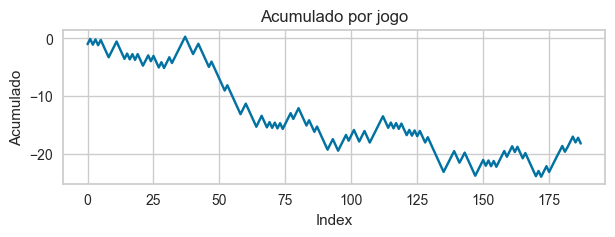

ExtraTreesClassifier (i = 5)

PL: -15.55 | ROI: -8.41% | Prec.: 0.53
Odd média: 1.80 (0.55 WR)
Média Gain: 0.73 | Média Loss: -1.00
EM: -0.08
185 entradas em 350 jogos (52.86%)


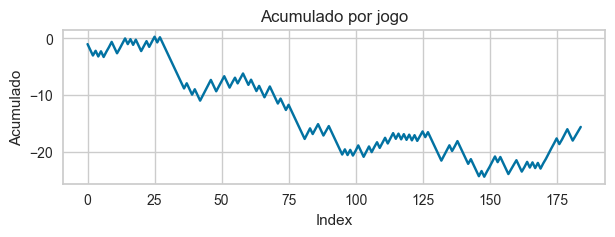

RandomForestClassifier (i = 6)

PL: -7.02 | ROI: -4.01% | Prec.: 0.53
Odd média: 1.86 (0.54 WR)
Média Gain: 0.83 | Média Loss: -1.00
EM: -0.03
175 entradas em 350 jogos (50.00%)


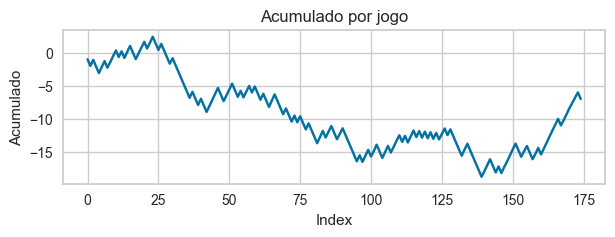

GradientBoostingClassifier (i = 7)

PL: -17.35 | ROI: -8.99% | Prec.: 0.53
Odd média: 1.79 (0.56 WR)
Média Gain: 0.71 | Média Loss: -1.00
EM: -0.10
193 entradas em 350 jogos (55.14%)


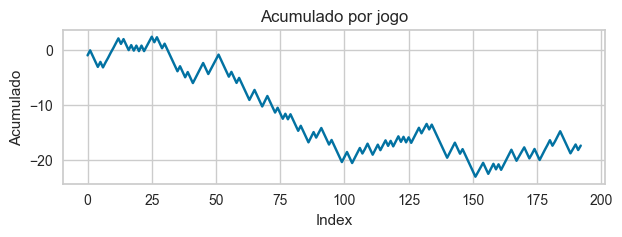

DecisionTreeClassifier (i = 8)

PL: -21.01 | ROI: -11.74% | Prec.: 0.50
Odd média: 1.82 (0.55 WR)
Média Gain: 0.76 | Média Loss: -1.00
EM: -0.12
179 entradas em 350 jogos (51.14%)


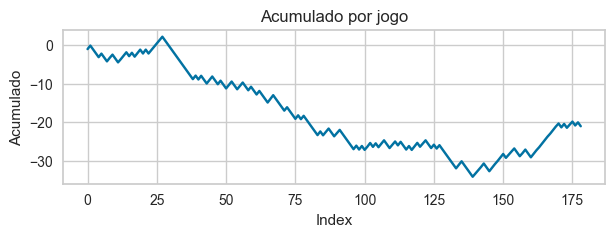

LinearDiscriminantAnalysis (i = 9)

PL: 0.70 | ROI: 0.39% | Prec.: 0.53
Odd média: 1.91 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.01
180 entradas em 350 jogos (51.43%)


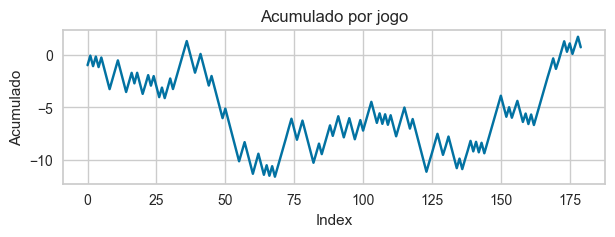

AdaBoostClassifier (i = 10)

PL: -21.76 | ROI: -10.07% | Prec.: 0.55
Odd média: 1.76 (0.57 WR)
Média Gain: 0.65 | Média Loss: -1.00
EM: -0.09
216 entradas em 350 jogos (61.71%)


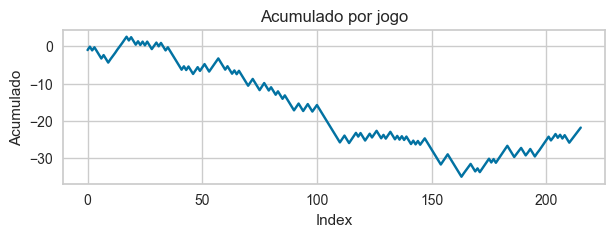

GaussianNB (i = 11)

PL: 4.47 | ROI: 2.40% | Prec.: 0.54
Odd média: 1.91 (0.52 WR)
Média Gain: 0.90 | Média Loss: -1.00
EM: 0.03
186 entradas em 350 jogos (53.14%)


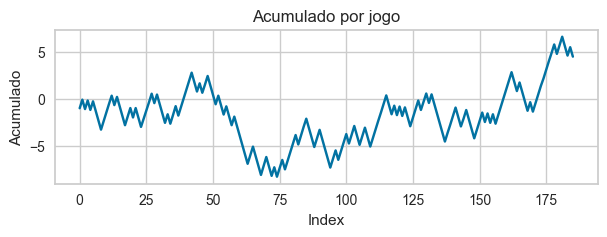

QuadraticDiscriminantAnalysis (i = 12)

PL: -13.82 | ROI: -16.65% | Prec.: 0.66
Odd média: 1.47 (0.68 WR)
Média Gain: 0.26 | Média Loss: -1.00
EM: -0.17
83 entradas em 350 jogos (23.71%)


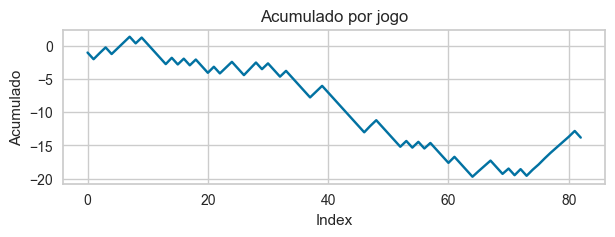

O modelo apresentou um erro.



In [84]:
FILTRO = 1
CONJUNTO = 'teste'

for i in range(14):
    try:
        if CONJUNTO == 'val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], val1)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([val1, val2]), filtro = FILTRO)
        elif CONJUNTO == 'teste_val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], real_teste)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([real_teste, val]), filtro = FILTRO)
        elif CONJUNTO == 'teste':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux = info_modelo(top[i], real_teste, filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

In [ ]:
blended710 = blend_models(estimator_list = [top[10], top[7]], fold = 5, verbose=False)

In [ ]:
model_list = [top[7], top[10], blended710]

### Resultados

In [ ]:
FILTRO = 1

for item in model_list:
    try:
        print(f'{item.__class__.__name__}\n')
        aux_total = treina_modelo(item, real_teste)
        aux_total = filtra_resultados(aux_total, filtro = FILTRO)
        plt.axvline(x=len(aux_total), color='red', linestyle='--')
        aux = info_modelo(item, pd.concat([real_teste, val]), filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

# Script qcut

In [ ]:
# df_cut1 = df_treino.copy()
df_cut = df_comp.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [ ]:
variaveis = features.copy()
variaveis.append('prediction_score')

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 7, duplicates='drop')

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

In [ ]:
_df = _df[((_df['CV_ML'] >= 0) & (_df['CV_ML'] < 0.65)) | ((_df['CV_ML'] >= 0.77) & (_df['CV_ML'] < 0.87)) | ((_df['CV_ML'] >= 0.95) & (_df['CV_ML'] < 1.5))]

_df = _df[((_df['P_Diff'] < 0.42) | (_df['P_Diff'] > 0.44))]


In [ ]:
# display(df_cut2.groupby('Cat_DP_Odds_Geral_H')['DP_Odds_Geral_H'].describe())

# Script variáveis

In [24]:
colunas = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA']

colunas = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA']

In [25]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(5, 12)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [26]:
def cria_modelo(fts, _seed = 2023, _filtro = 0):
        try:
                cria_setup(features=fts, seed = _seed)

                model = create_model('nb', verbose = False, fold = 5)
                tab = pull()
                prec_model = (tab.loc['Mean', 'Prec.'])
                previsoes = predict_model(model, verbose = False)

                stake = 1

                total = previsoes.shape[0]

                previsoes = previsoes[previsoes['prediction_label'] == 1]
                previsoes = filtra_resultados(previsoes, filtro = _filtro)

                previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
                previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

                plb = previsoes['PL_BF_Predictions'].sum()
                entradas = previsoes.shape[0]
                wr = round((previsoes[previsoes[TARGET] == 1].shape[0] / entradas), 2)
                oddback = previsoes[previsoes['prediction_label'] == 1][ODDS].mean()
                med_gain = previsoes[previsoes[TARGET] == 1]['PL_BF_Predictions'].mean()
                med_loss = previsoes[previsoes[TARGET] == 0]['PL_BF_Predictions'].mean()
                roi = plb / entradas
                porc_ent = entradas / total
                ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

                metrics = [prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]

                return metrics
        except Exception as e:
                print(e)
                return [0, 0, 0, 0, 0, 0, 0, 0, 0]

In [27]:
melhor_PL = -10000

for i in range(20):
    feats = pegar_elementos_aleatorios(colunas)
    feats.append(ODDS)

    metrics = cria_modelo(fts=feats)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
            
    print(f'Rodada {i+1}')
    if plb > melhor_PL:
        melhor_PL = plb
        print(f'**Novo melhor**')
        print(f'Precision: {prec_model:.4f}')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'features = {feats}\n')
    print()

Rodada 1
**Novo melhor**
Precision: 0.5656
PL: -3.95 | ROI: -2.26% | EM: -0.03 | Prec.: 0.51 | Entradas: 0.50
features = ['Odds_H', 'HA_Line', 'CV_Over', 'Odds_A', 'P(H)', 'CV_ML', 'HA_Odds_H', 'Odds_Over', 'P_Diff', 'P(U)', 'Odds_Over']


Rodada 2
**Novo melhor**
Precision: 0.5730
PL: -2.00 | ROI: -1.06% | EM: -0.01 | Prec.: 0.52 | Entradas: 0.54
features = ['P(U)', 'Odds_Over', 'Odds_H', 'HA_Odds_H', 'Over_Line', 'CV_HA', 'P_Diff', 'P(H)', 'P(A)', 'Odds_A', 'CV_ML', 'HA_Odds_A', 'Odds_Over']


Rodada 3

Rodada 4

Rodada 5

Rodada 6

Rodada 7

Rodada 8
**Novo melhor**
Precision: 0.5620
PL: -1.34 | ROI: -0.73% | EM: -0.01 | Prec.: 0.52 | Entradas: 0.53
features = ['HA_Odds_A', 'CV_HA', 'Odds_H', 'Odds_Under', 'P_Diff', 'HA_Odds_H', 'CV_ML', 'Odds_A', 'P(O)', 'Odds_Over', 'P(U)', 'Odds_Over']


Rodada 9

Rodada 10

Rodada 11

Rodada 12

Rodada 13
**Novo melhor**
Precision: 0.5832
PL: -0.03 | ROI: -0.02% | EM: 0.01 | Prec.: 0.53 | Entradas: 0.57
features = ['Odds_Under', 'P(U)', 'Over_Li

# Segundo filtro

In [30]:
fits = ['Odds_A', 'CV_ML', 'P(U)', 'P(O)', 'Odds_Over', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']

fits = ['Odds_A', 'CV_ML', 'P(U)', 'P(O)', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']


In [31]:
metrics = cria_modelo(fits)
prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

print('---------------------- BASE ----------------------')
print(f'Precision: {prec_model:.4f}')
print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
print(f'fits = {fits}\n')
print('--------------------------------------------------')
melhor_PL = plb

for i in range(len(fits) - 1):
    feat = fits[i]
    fits.pop(i)
    print(f'Removido: {feat}')

    metrics = cria_modelo(fits)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

    if plb >= melhor_PL:
        print('*** NOVO MELHOR ***')
        melhor_PL = plb
    print(f'Precision: {prec_model:.4f}')
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
    print(f'fits = {fits}\n')
    fits.insert(i, feat)
    print()

---------------------- BASE ----------------------
Precision: 0.5573
PL: 5.38 | ROI: 2.88% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.53
fits = ['Odds_A', 'CV_ML', 'P(U)', 'P(O)', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']

--------------------------------------------------
Removido: Odds_A
Precision: 0.5480
PL: 4.19 | ROI: 2.37% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.51
fits = ['CV_ML', 'P(U)', 'P(O)', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']


Removido: CV_ML
Precision: 0.5659
PL: -1.64 | ROI: -0.91% | EM: -0.01 | Prec.: 0.52 | Entradas: 0.52
fits = ['Odds_A', 'P(U)', 'P(O)', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']


Removido: P(U)
Precision: 0.5727
PL: 1.76 | ROI: 1.04% | EM: 0.01 | Prec.: 0.53 | Entradas: 0.49
fits = ['Odds_A', 'CV_ML', 'P(O)', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']


Removido: P(O)
Precision: 0.5582
PL: 3.95 | ROI: 2.26% | EM: 0.03 | Prec.: 0.54 | Entradas: 0.50
fits = ['Odds_A', 'CV_ML',

# Cross validation

Fold 1 (seed 4998)
PL: 14.51 | ROI: 4.77% | EM: 0.06 | Prec.: 0.57 | Entradas: 0.33


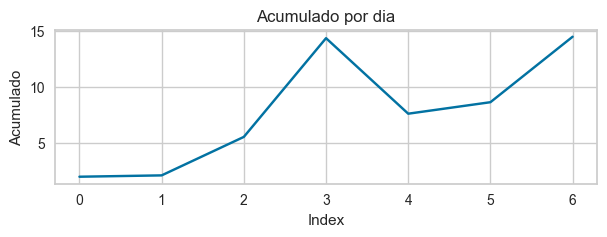


Fold 2 (seed 5894)
PL: -3.50 | ROI: -1.21% | EM: -0.01 | Prec.: 0.55 | Entradas: 0.31


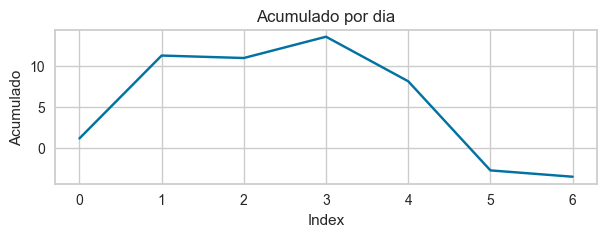


Fold 3 (seed 9047)
PL: 4.56 | ROI: 1.34% | EM: 0.01 | Prec.: 0.56 | Entradas: 0.37


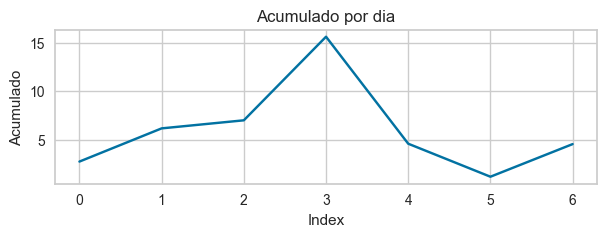


Fold 4 (seed 9279)
PL: 11.71 | ROI: 3.98% | EM: 0.04 | Prec.: 0.56 | Entradas: 0.32


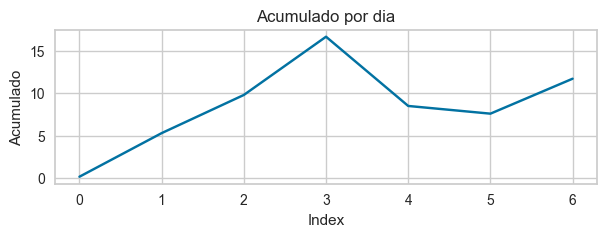


Fold 5 (seed 7537)
PL: 4.59 | ROI: 2.38% | EM: 0.02 | Prec.: 0.54 | Entradas: 0.21


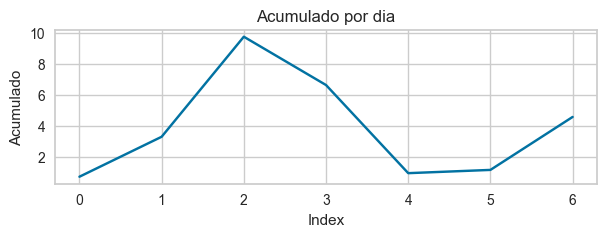


Fold 6 (seed 1505)
PL: 9.87 | ROI: 3.71% | EM: 0.05 | Prec.: 0.58 | Entradas: 0.29


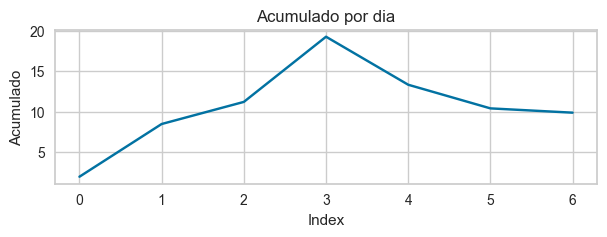


Fold 7 (seed 7536)
PL: 12.78 | ROI: 4.79% | EM: 0.05 | Prec.: 0.58 | Entradas: 0.29


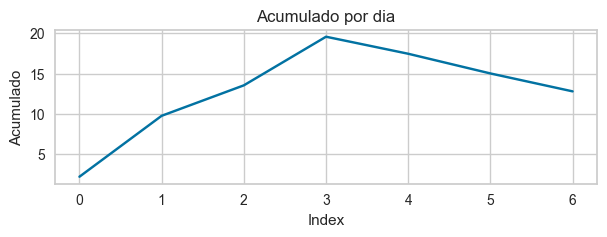


Fold 8 (seed 8350)
PL: 0.31 | ROI: 0.10% | EM: -0.00 | Prec.: 0.55 | Entradas: 0.35


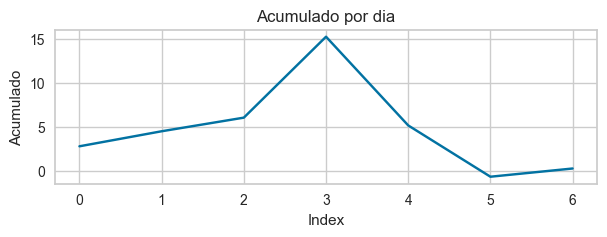


Fold 9 (seed 5283)
PL: 4.33 | ROI: 2.16% | EM: 0.03 | Prec.: 0.55 | Entradas: 0.22


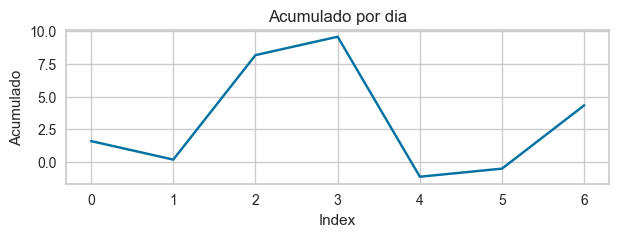


Fold 10 (seed 6110)
PL: 10.13 | ROI: 4.35% | EM: 0.04 | Prec.: 0.58 | Entradas: 0.25


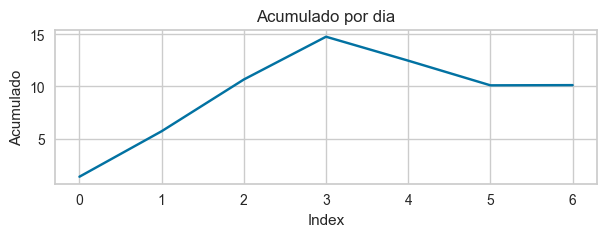


Média: 0.56 | DP: 0.01


In [92]:
results = []
seeds = random.sample(range(0, 9999), 10)

for i in range(len(seeds)):

        cria_setup(seed=seeds[i], features=features)

        cross_model = create_model('nb', verbose = False, cross_validation=False)
        
        previsoes = predict_model(cross_model, val, verbose = False)
        previsoes = previsoes.merge(df[ODDS], left_index=True, right_index=True, how='left')
        if f'{ODDS}_x' in previsoes.columns.tolist():
                previsoes.rename(columns={f'{ODDS}_x': ODDS}, inplace=True)
                previsoes.drop(columns=f'{ODDS}_y', inplace=True)

        stake = 1

        total = previsoes.shape[0]

        previsoes = previsoes[(previsoes['prediction_label'] == 1)]

        previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
        previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

        ############ Filtro ############
        previsoes = filtra_resultados(previsoes, filtro = 1)
        previsoes = calcula_profit(previsoes)
        metrics = exibe_metricas(previsoes, total = total, return_metrics=True)
        plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
        
        results.append(wr)

        print(f'Fold {i+1} (seed {seeds[i]})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        exibe_grafico(previsoes, per_day=True)
        print()

print(f'Média: {np.mean(results):.2f} | DP: {np.std(results):.2f}')

In [ ]:
775
5307
8909

# Entradas Aleatórias

In [45]:
def new_random_model(_val, _n):

    for i in range(_n):
        random_df = _val.copy()
        random_df['Entrada'] = [random.choice([0, 1]) for _ in range(len(random_df))]

        random_df = random_df[random_df['Entrada'] == 1]
        random_df.loc[(random_df[TARGET] == 1), 'PL'] = (random_df[ODDS] - 1)
        random_df.loc[(random_df[TARGET] == 0), 'PL'] = - 1
        
        random_df.sort_values('Date', inplace=True)
        random_df.reset_index(drop=True, inplace=True)
        random_df['hbacu'] = random_df['PL'].cumsum()
        random_df['hbacu'].plot.line(figsize=(12,6))
    
    plt.show()

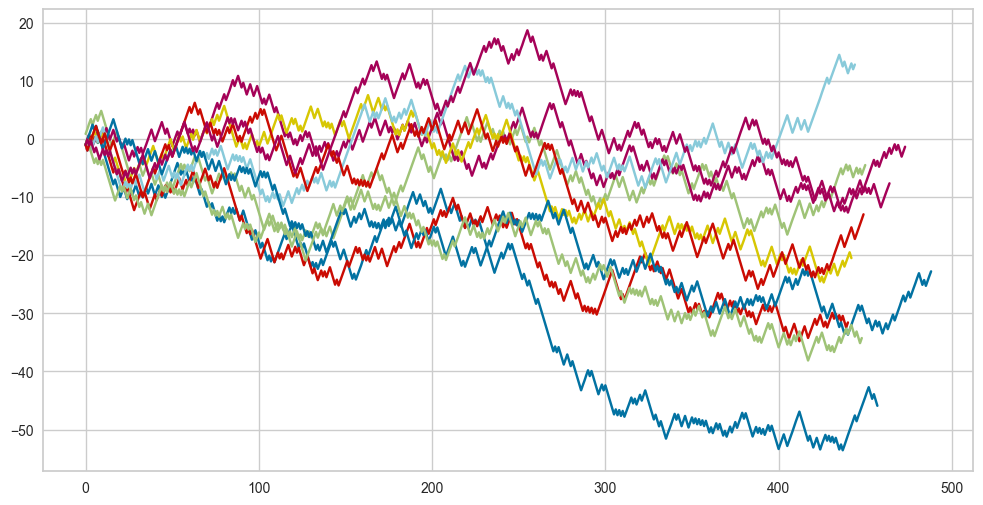

In [47]:
new_random_model(val, 10)